# Unsupervised Learning - Autoencoders
by [David Ohm](http://ohmdsp.github.io/)
/ [GitHub](https://github.com/ohmdsp)

In this notebook, we will explore some neural networks for unsupervised learning. This will give us some tools to explore data in some very interesting ways.

Machine learning with deep neural networks can be classified into two categories:  (1) Unsupervised Learning - You have a lot of data and you want to learn something about the data (e.g., patterns, clustering, reduce dimensionality, generating new data, etc.), and (2) Supervised Learning - You know what you want to learn using your data and you have labeled training data.  We are going to explore the autoencoder.

## Autoencoders

![Autoencoder](images/autoencoder.png)

An autoencoder is a type of neural network that learns to encode a lower dimension representation of its input data.  It can also reproduce the original input data using a decoding process. An autoencoder does not require "labels" to learn.  Instead, it tries to generate an output that is the same as the input. For example, if an image is input, the output from the decoder will be the same image. In this notebook, we will see why this is interesting. 

It is worth mentioning two interesting practical applications of autoencoders: (1)data denoising, and (2)dimensionality reduction for data visualization. In many cases, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

In [6]:
# imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# Some additional libraries to produce some visualizations for training
from PIL import Image
from libs.utils import montage
#from libs import gif
#import IPython.display as ipyd
plt.style.use('ggplot')
#from PIL import Image

#import keras
from tensorflow.python.keras.layers import Activation, Dense, Input, Lambda, Layer
from tensorflow.python.keras.layers import Conv2D, Flatten, MaxPooling2D, UpSampling2D
from tensorflow.python.keras.layers import Reshape, Conv2DTranspose
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.losses import mse, binary_crossentropy
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import metrics

Let's load in some MNIST data to use for examples.

In [7]:
from tensorflow.python.keras.datasets import mnist

In [8]:
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [9]:
print(x_train.shape)

(60000, 28, 28)


In [10]:
# Select 1000 images from the training set for dispay
images = x_train[0:1000]

In [11]:
# Let's take a look at one of these images
img = x_train[0]

In [12]:
img.shape

(28, 28)

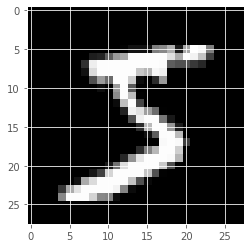

In [13]:
plt.imshow(img, cmap='gray')

Now, we can display a montage of the 1000 images from this training dataset.

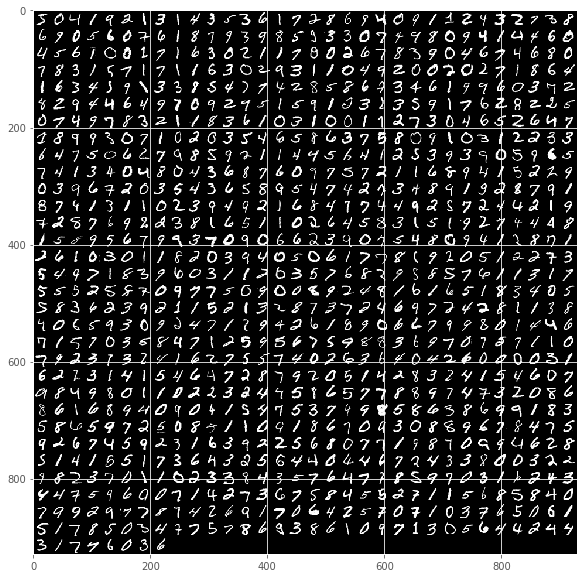

In [14]:
plt.rcParams["figure.figsize"] = (14,10)   # set plot sizes
# Then create a montage and draw the montage
plt.imshow(montage(images), cmap='gray')

Like we did in the preprocessing notebook, let's take a look at the mean of 1000 images from this dataset.

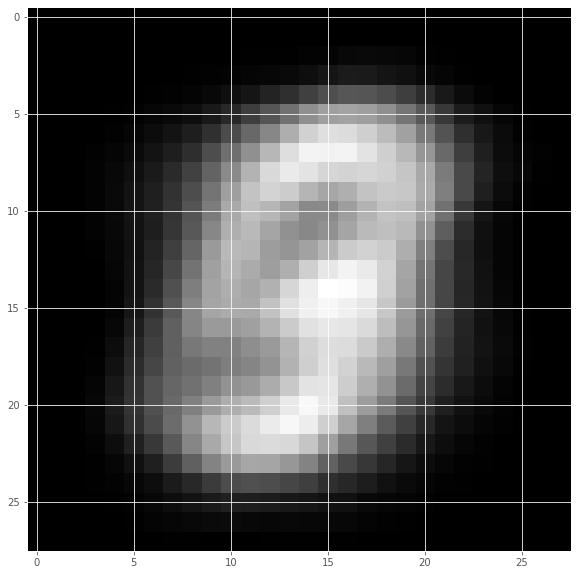

In [15]:
# Take the mean across all 1000 images
mean_img = np.mean(images, axis=0)

# Then plot the mean image.
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')


## Simple Autoencoder  - Fully Connected Model

We will start with the most basic autoencoder using a fully connected model.  From the original 784 (i.e., 28x28) neurons, we're going to reduce the image dimensions.

In [16]:
#Define the dimension to reduce the original image(s) to
encoding_dim = 32

In [17]:
# placeholder for input
input_img = Input(shape = (784,))

In [18]:
# create autoencoder model
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded) 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
# create seperate encoder model
encoder = Model(input_img, encoded)

In [20]:
# Create decoder model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [21]:
# configure the autoencoder model to use per-pixel crossentropy loss and an optimizer
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1.0), loss='binary_crossentropy')
#autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=.001), loss='binary_crossentropy',metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
# Create the data for training
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [23]:
# Run the autoencoder training
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 45us/sample - loss: 0.3631 - val_loss: 0.2722
Epoch 2/50
60000/60000 [==============================] - 1s 9us/sample - loss: 0.2662 - val_loss: 0.2568
Epoch 3/50
60000/60000 [==============================] - 1s 10us/sample - loss: 0.2470 - val_loss: 0.2347
Epoch 4/50
60000/60000 [==============================] - 1s 10us/sample - loss: 0.2260 - val_loss: 0.2152
Epoch 5/50
60000/60000 [==============================] - 1s 9us/sample - loss: 0.2094 - val_loss: 0.2014
Epoch 6/50
60000/60000 [==============================] - 1s 10us/sample - loss: 0.1978 - val_loss: 0.1918
Epoch 7/50
60000/60000 [==============================] - 1s 10us/sample - loss: 0.1894 - val_loss: 0.1844
Epoch 8/50
60000/60000 [==============================] - 1s 10us/sample - loss: 0.1826 - val_loss: 0.1782
Epoch 9/50
60000/60000 [==============================] - 1s 10us/sample - loss: 0.1768 - val_lo

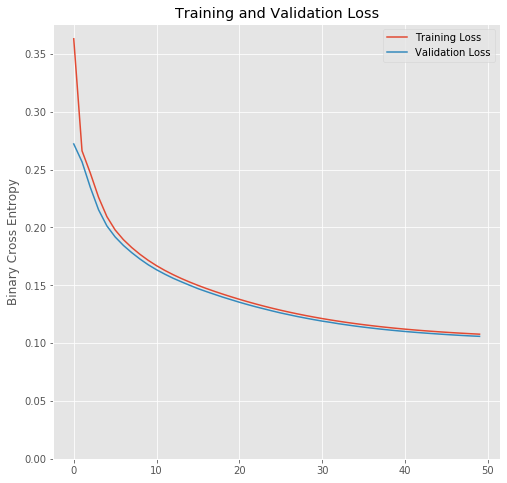

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#encode and decode some digits. Note: we use images from the test dataset
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [26]:
encoded_imgs.mean()

6.9097013

Let's compare some input images to their output images from the autoencoder. You will see that the image reconstruction is not perfect. 

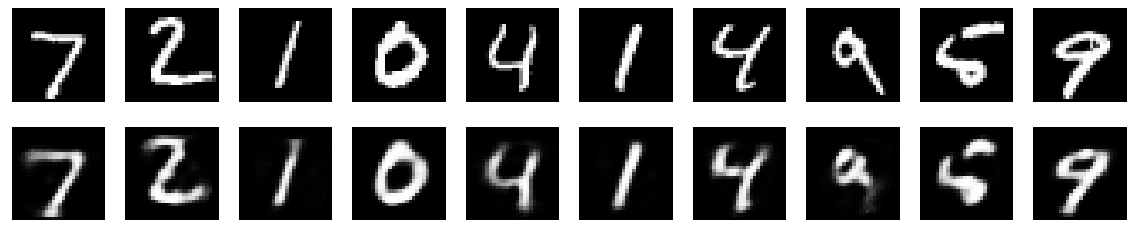

In [27]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

So far, the latent representations of our input images have been constrained by the size of the hidden layer of 32. With a simple neural network like this, the hidden layer is learning an approximation of PCA (principal component analysis). 

Another way we can  constrain the representations to be small (e.g., compressed) is to add a sparsity contraint on the activation function of the hidden layer, so fewer neurons will "fire" each computation. In Keras, this can be done by adding an activity_regularizer to our Dense layer (see next cell). We will not explore this here, but you can experiment on your own.

In [28]:
# add a Dense layer with a L1 activity regularizer
#encoded = Dense(encoding_dim, activation='relu',
#                activity_regularizer=regularizers.l1(10e-5))(input_img)

## Deep Autonencoder

We are not limited to a single layer in the encoder. We could add a stack of layers - making the network deeper.

In [29]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [30]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [31]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1.0), loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136

In [32]:
history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 14us/sample - loss: 0.3210 - val_loss: 0.2626
Epoch 2/20
60000/60000 [==============================] - 1s 12us/sample - loss: 0.2562 - val_loss: 0.2487
Epoch 3/20
60000/60000 [==============================] - 1s 11us/sample - loss: 0.2388 - val_loss: 0.2273
Epoch 4/20
60000/60000 [==============================] - 1s 12us/sample - loss: 0.2184 - val_loss: 0.2085
Epoch 5/20
60000/60000 [==============================] - 1s 12us/sample - loss: 0.1990 - val_loss: 0.1869
Epoch 6/20
60000/60000 [==============================] - 1s 12us/sample - loss: 0.1848 - val_loss: 0.1795
Epoch 7/20
60000/60000 [==============================] - 1s 11us/sample - loss: 0.1783 - val_loss: 0.1730
Epoch 8/20
60000/60000 [==============================] - 1s 12us/sample - loss: 0.1726 - val_loss: 0.1699
Epoch 9/20
60000/60000 [==============================] - 1s 12us/sample - loss: 0.1668 - val_

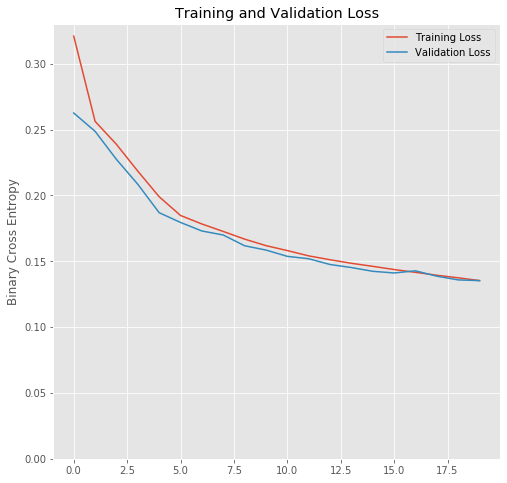

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [34]:
#encode and decode some digits from test set
decoded_imgs = autoencoder.predict(x_test)

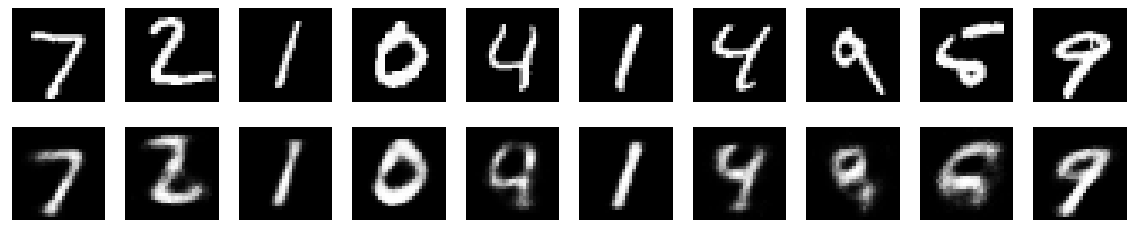

In [35]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The deeper model looks to generate slightly better results, but it is not a dramatic improvement over the simple model. Let's look at using convolutional layers.

## Convolutional Autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders -- they simply perform much better.

Let's implement a convolutional autoencoder to see how it performs. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [36]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [37]:
input_img = Input(shape=(28, 28, 1))

In [38]:
# Define our encoder network
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

In [39]:
# Define our decoder network
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [40]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1.0), loss='binary_crossentropy')

In [41]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [42]:
#from keras.callbacks import TensorBoard

history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 52us/sample - loss: 0.2108 - val_loss: 0.1618
Epoch 2/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1534 - val_loss: 0.1428
Epoch 3/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1403 - val_loss: 0.1399
Epoch 4/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1318 - val_loss: 0.1273
Epoch 5/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1257 - val_loss: 0.1190
Epoch 6/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1215 - val_loss: 0.1185
Epoch 7/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1187 - val_loss: 0.1156
Epoch 8/20
60000/60000 [==============================] - 2s 32us/sample - loss: 0.1163 - val_loss: 0.1144
Epoch 9/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1147 - val_

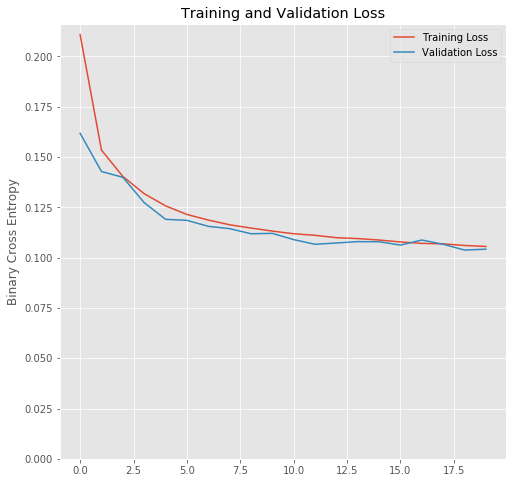

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [44]:
#encode and decode some digits from test set
decoded_imgs = autoencoder.predict(x_test)

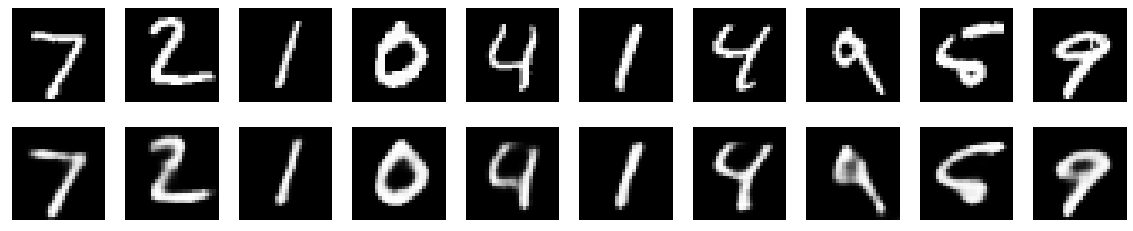

In [45]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The results from the convolutional autoencoder are better. It is especially apparent with the 9 and 2 digits.

We can also look at the encoded representations. These are shaped as 8x4x4 so we need to reshape them to 4x32 to display.

In [46]:
# create seperate encoder model
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

In [47]:
encoded_imgs[0].shape

(4, 4, 8)

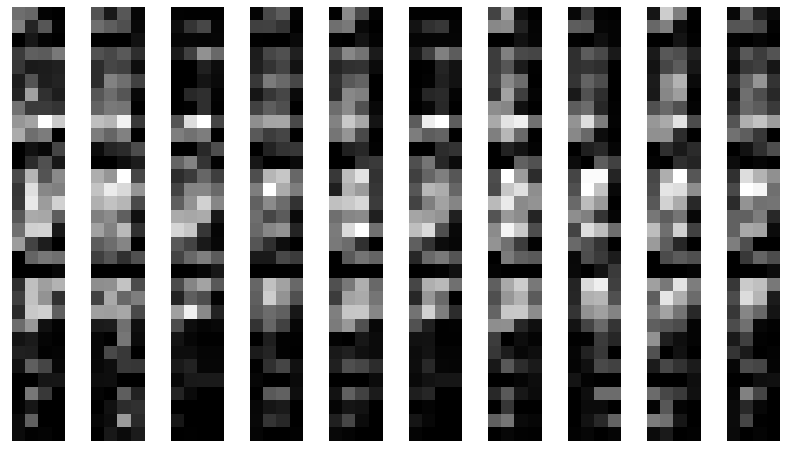

In [48]:
n = 10
plt.figure(figsize=(14, 8))
for i in range(n):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Denoising Autoencoder

The denoising autoencoder is a very simple extension to an autoencoder, and it can be a useful tool in the hands of a signal processing engineer.  We will use an convolutional autoencoder to work on a toy image denoising problem. We will train the autoencoder to map noisy digits images to clean digits images. Note - we will simulate the noisy data by adding noise to images from the MNIST dataset.

In [49]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [50]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [51]:
# Generate noisy MNIST images by adding noise with normal dist centered at 0.5 and variance of 0.5
noise = np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = x_train + 0.5*noise
noise = np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = x_test + 0.5*noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Let's look at some of the noisy digits:

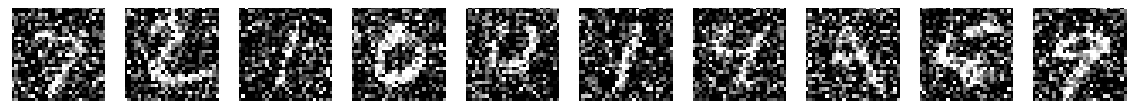

In [52]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We will use a slightly different model for denoising that has more filters per layer.

In [53]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [54]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1.0), loss='binary_crossentropy')

In [55]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 2s 36us/sample - loss: 0.1788 - val_loss: 0.1226
Epoch 2/25
60000/60000 [==============================] - 2s 32us/sample - loss: 0.1193 - val_loss: 0.1154
Epoch 3/25
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1115 - val_loss: 0.1066
Epoch 4/25
60000/60000 [==============================] - 2s 32us/sample - loss: 0.1076 - val_loss: 0.1038
Epoch 5/25
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1054 - val_loss: 0.1033
Epoch 6/25
60000/60000 [==============================] - 2s 32us/sample - loss: 0.1038 - val_loss: 0.1030
Epoch 7/25
60000/60000 [==============================] - 2s 33us/sample - loss: 0.1028 - val_loss: 0.1034
Epoch 8/25
60000/60000 [==============================] - 2s 33us/sample - loss: 0.1021 - val_loss: 0.1008
Epoch 9/25
60000/60000 [==============================] - 2s 32us/sample - loss: 0.1014 - val_

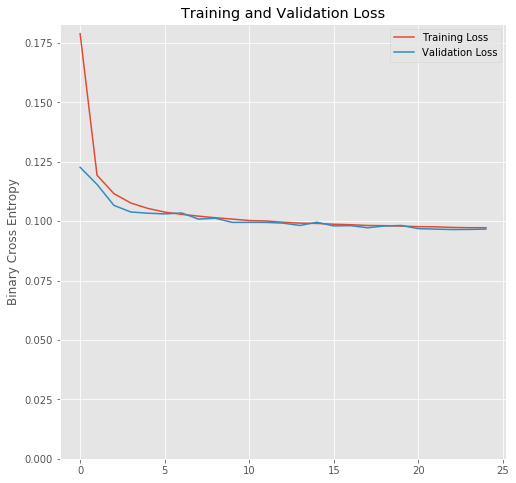

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [57]:
# Predict the Autoencoder output from corrupted test images
decoded_imgs = autoencoder.predict(x_test_noisy)

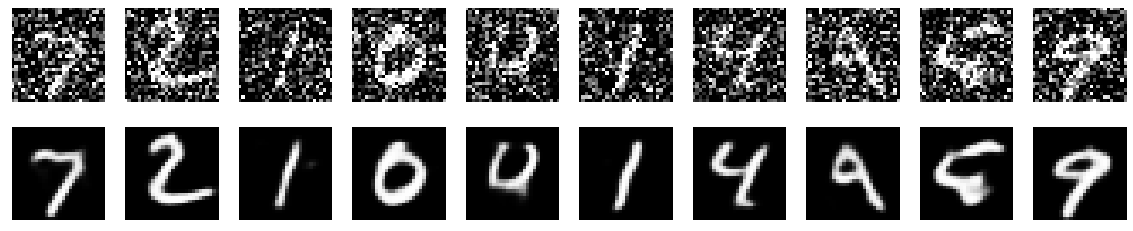

In [58]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational Autoencoder (VAE)

A variational autoencoder a type of autoencoder with constraints on the encoded representations that can be learned. It learns a latent variable model for the input data. So, instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution for modeling your data. If you sample points from this distribution, you can generate new input data samples. For this reason a VAE is considered a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma (i.e., the mean and log of variance for a normal distribution). Then, we randomly sample points z from that latent normal distribution, using z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal distribution. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the nearal network are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. It is not required to use the KL term, although it helps in learning well-formed latent spaces and reducing overfitting to the training data.

Let's build one!

In [59]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [60]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [61]:
x_train.shape

(60000, 784)

In [62]:
# network parameters
input_shape = (original_dim, )
print(input_shape)
intermediate_dim = 512
batch_size = 100
latent_dim = 2
epochs = 50
epsilon_std = 1.0 # standard deviation of normal distribution used to sample latent values

(784,)


In [63]:
# VAE model = encoder + decoder
x = Input(shape= (original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_var = Dense(latent_dim, name='z_log_var')(h)

In [64]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments - args (tensor): mean and log of variance of Q(z|X)

    # Returns - z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim),mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [65]:
# The reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [66]:
# build decoder model
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [67]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [68]:
#def vae_loss(x, x_decoded_mean):
#    xent_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#    return k.mean(xent_loss + kl_loss)

In [69]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer=tf.keras.optimizers.RMSprop(lr=.001), loss=None)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
______________________________________________________________________________________________

### We can create an anomoly
For fun and exploration, let's remove a digit from the dataset to simulate an anomoly. We can explore methods for anomoly detection later.

In [70]:
anomalous_digit = 8

In [71]:
# remove anomalous digit from train data
train_mask = np.where(y_train!=anomalous_digit)[0]
x_train = x_train[train_mask, :]
y_train = y_train[train_mask]

# create binary labels
test_mask = np.where(y_test != anomalous_digit)[0]
y_test_binary = np.zeros(y_test.shape[0])
y_test_binary[test_mask] = 1

In [72]:
history = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
54149/54149 [==============================] - 2s 31us/sample - loss: 184.4599
Epoch 2/50
54149/54149 [==============================] - 2s 28us/sample - loss: 165.9850
Epoch 3/50
54149/54149 [==============================] - 1s 27us/sample - loss: 162.3818
Epoch 4/50
54149/54149 [==============================] - 2s 28us/sample - loss: 159.6736
Epoch 5/50
54149/54149 [==============================] - 2s 28us/sample - loss: 157.4423
Epoch 6/50
54149/54149 [==============================] - 1s 27us/sample - loss: 155.7671
Epoch 7/50
54149/54149 [==============================] - 1s 27us/sample - loss: 154.5580
Epoch 8/50
54149/54149 [==============================] - 1s 28us/sample - loss: 153.6202
Epoch 9/50
54149/54149 [==============================] - 1s 27us/sample - loss: 152.9493
Epoch 10/50
54149/54149 [==============================] - 2s 28us/sample - loss: 152.3675
Epoch 11/50
54149/54149 [==============================] - 1s 28us/sample - loss: 151.8893
Epoch 12

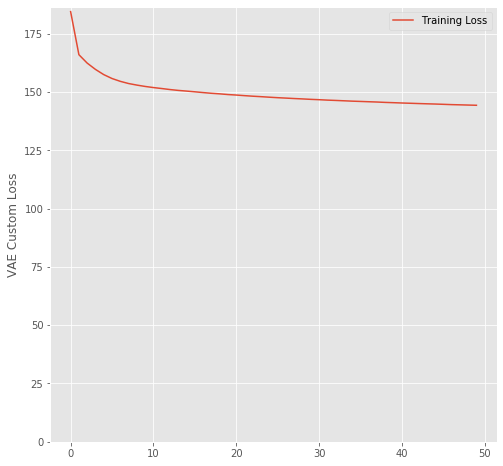

In [73]:
loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('VAE Custom Loss')
plt.ylim([0,max(plt.ylim())])
#plt.title('Training and Validation Loss')
plt.show()

## Visualize the Learned Latent Distribution

A variational autoencoder allows us to inspect the latent space to learn more about our model and our data.  For example, in anomaly detection, latent variables can be used to try and determine the cause of anomalies.  
In the case that we have 2 latent dimensions we can easily visualize the representation.  With higher dimensionality we can use dimensionality reducing techniques such as PCA or t-SNE to visualize.

In [74]:
# build a model to project inputs on to the latent space
encoder = Model(x, z_mean)

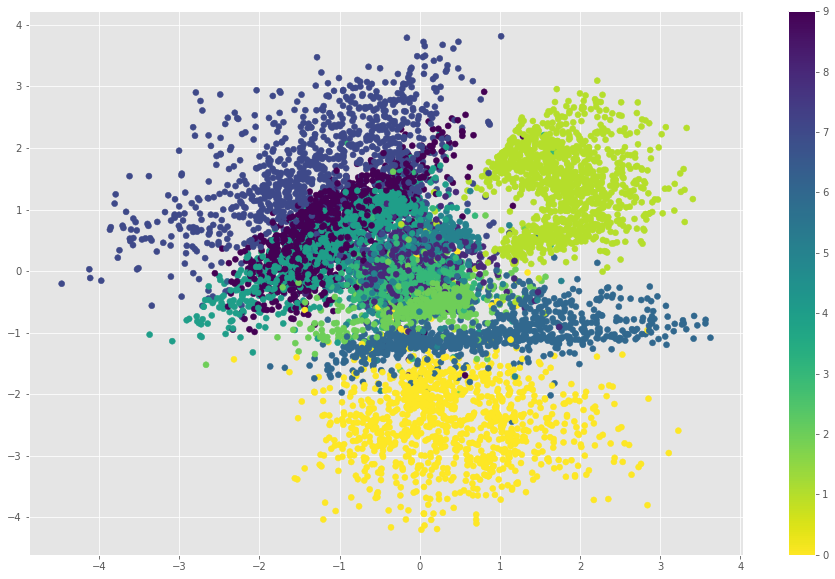

In [75]:
if latent_dim == 2:
    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(16, 10))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis_r')
    plt.colorbar()
    plt.show()

In [76]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

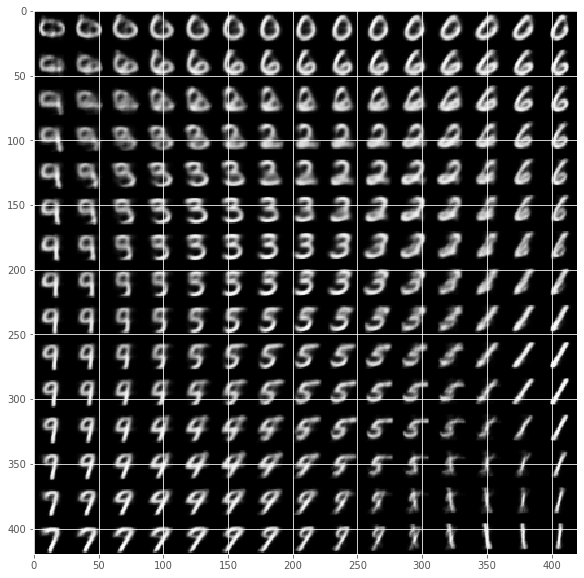

In [77]:
# display a 2D manifold of the digits
from scipy.stats import norm
epsilon_std = 1
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit       
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Anomaly Detection

We detect anomalies by computing the probability that our reconstructed datapoint came from the ground truth.  To do this, we reconstruct (run through autoencoder) all of the data in our test set and then compute the binary cross-entropy between ground truth digits and our reconstruction.  

In [78]:
# compute sigmoid output of the autoencoder (without variational parts)
sigmoid_output = Model(x, x_decoded_mean)

In [79]:
# compute reconstructions of the test set
x_test_recons = sigmoid_output.predict(x_test)

To get the likelihood of our reconstruction we compute exponential of the negative cross-entropy.

In [80]:
def recon_prob(output, target):
    xent = -(target*np.log(output + .0000001) + (1.0 - target) * np.log(1.0 - output + .0000001))
    xent = np.mean(xent, axis=1)
    return np.exp(-xent)

probs = recon_prob(x_test_recons, x_test)

We can learn about the effectiveness of our anomaly detector by visualizing the results.  Below we randomly sample ten images at a time from the test set, then display the original image with the output reconstruction.

image index: 2928 normal: 1.0 probability: 0.9462712
image index: 2821 normal: 1.0 probability: 0.85248864
image index: 9732 normal: 0.0 probability: 0.77688175
image index: 5211 normal: 1.0 probability: 0.9454565
image index: 8274 normal: 1.0 probability: 0.83874726
image index: 448 normal: 1.0 probability: 0.81872004
image index: 7182 normal: 1.0 probability: 0.82352453
image index: 5927 normal: 1.0 probability: 0.8394287
image index: 8342 normal: 1.0 probability: 0.81530297
image index: 9943 normal: 1.0 probability: 0.8128829


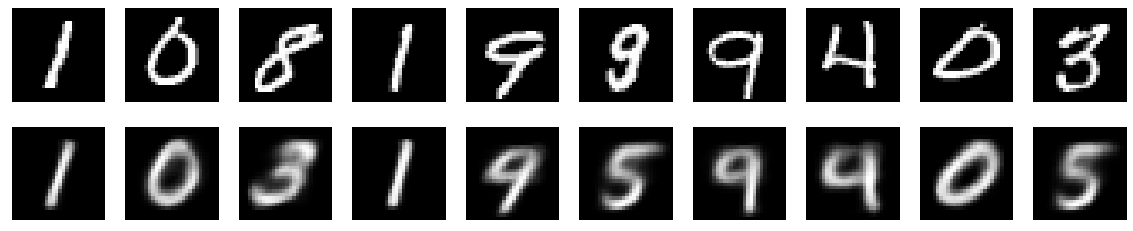

In [81]:
# plot original digit, reconstruction, and probability
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    img_idx = np.random.randint(0,y_test.shape[0])
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It can be instructive to visualize what are the most normal images in our test set according to the model.

image index: 3741 normal: 1.0 probability: 0.9632512
image index: 5553 normal: 1.0 probability: 0.96837705
image index: 8659 normal: 1.0 probability: 0.96270484
image index: 6125 normal: 1.0 probability: 0.9603574
image index: 4869 normal: 1.0 probability: 0.96161985
image index: 4169 normal: 1.0 probability: 0.9613819
image index: 5534 normal: 1.0 probability: 0.9586238
image index: 8724 normal: 1.0 probability: 0.95819175
image index: 529 normal: 1.0 probability: 0.9580274
image index: 135 normal: 1.0 probability: 0.95762056


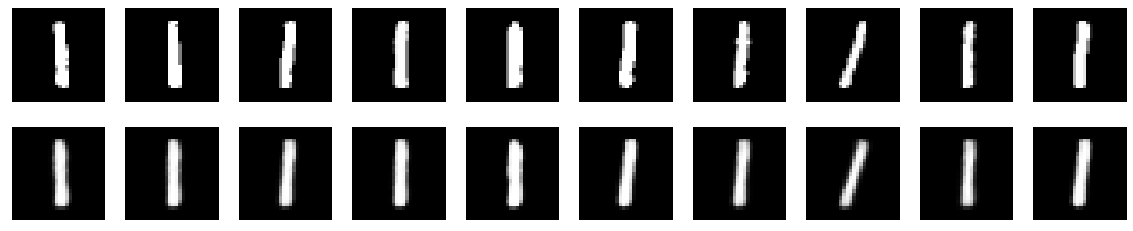

In [82]:
# plot n highest probability reconstructions
n = 10
ten_highest = np.argpartition(-probs, n)
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    img_idx = ten_highest[i-1]
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It's also helpful to visualize what are the most anomalous images according to our model.

image index: 6161 normal: 0.0 probability: 0.6149161
image index: 8015 normal: 0.0 probability: 0.55526596
image index: 2215 normal: 1.0 probability: 0.61227185
image index: 5409 normal: 1.0 probability: 0.616526
image index: 810 normal: 1.0 probability: 0.6232241
image index: 1325 normal: 0.0 probability: 0.6241658
image index: 3727 normal: 0.0 probability: 0.6198701
image index: 3364 normal: 0.0 probability: 0.621733
image index: 8000 normal: 1.0 probability: 0.5649809
image index: 2802 normal: 1.0 probability: 0.62662536


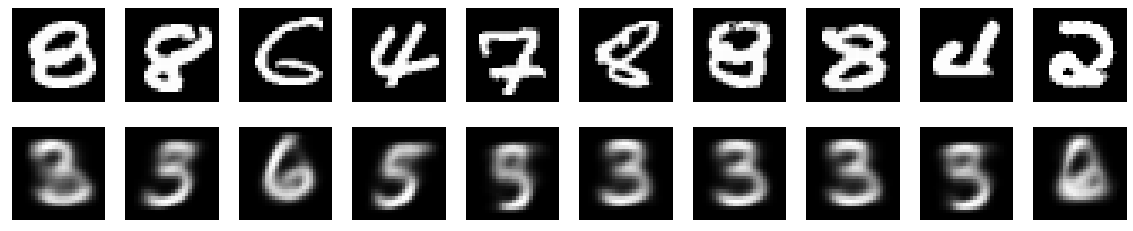

In [83]:
# plot n lowest probability reconstructions
n = 10
ten_highest = np.argpartition(probs, n)
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    img_idx = ten_highest[i-1]
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

__Question__: what can you say about the probabilities of your most anomalous digits?

__Try This__: Change the anomalous digit and retrain the model.  Is the anomaly detection model effective for digit?

__Try This__: Retrain the VAE without removing an anomalous digit. What do you notice about the images that are found to be anomalous?

## Model Evaluation

To evaluate the effectiveness of the model, we can use a ROC curve and compute the AUC (area-under-the-curve).  A diagonal line represents the performance similar to random chance (i.e., flipping a coin).  A quickly rising ROC curve indicates a well performing model.  Similarly, an AUC of .5 means random chance and a quickly rising AUC means the model is performing well.

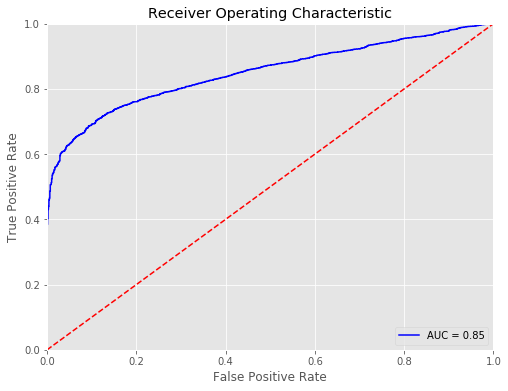

In [84]:
# compute the ROC curves
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc = roc_auc_score(y_test_binary, probs)
fpr, tpr, thresholds = roc_curve(y_test_binary, probs)

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

__Question__: How does the anomolous digit affect the AUC after retraining?

Since we learned the distribution underlying our data using the VAE, we can repeatedly sample the distribution to generate more data.  The more we sample, the lower variance our probability estimate will have due to averaging.

In [85]:
# compute reconstruction probabilities with lower variance. Note: this takes some time to compute.
num_samples = 100
all_probs = np.zeros((x_test.shape[0], num_samples))
for i in range(num_samples):
    
    x_test_recons = sigmoid_output.predict(x_test)
    
    probs = recon_prob(x_test_recons, x_test)

    all_probs[:, i] = probs

In [86]:
mean_probs = np.mean(all_probs, axis=1)

auc with sampling: 0.8508134838392941
auc: 0.8495794262616189


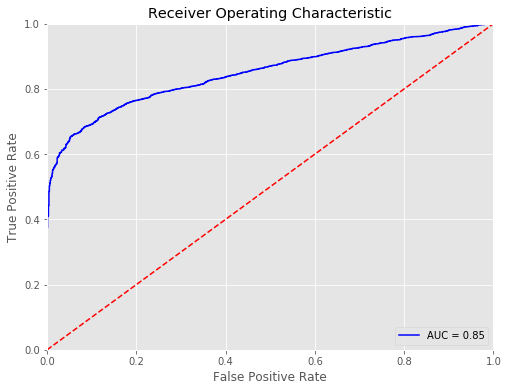

In [87]:
auc_with_sampling = roc_auc_score(y_test_binary, mean_probs)
print('auc with sampling: ' + str(auc_with_sampling))
print('auc: ' + str(auc))

fpr, tpr, thresholds = roc_curve(y_test_binary, mean_probs)

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As you can see, for this example there is not much difference in the ROC from generating more data. 